In [ ]:
import kagglehub
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print("Path to dataset files:" , path)

Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


In [ ]:
import keras, matplotlib, seaborn, sklearn, pandas, cv2
from PIL import Image

print("Keras:", keras.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Seaborn:", seaborn.__version__)
print("Scikit-learn:", sklearn.__version__)
print("PIL (Pillow):", Image.__version__)
print("OpenCV:", cv2.__version__)
print("Pandas:", pandas.__version__)


Keras: 3.8.0
Matplotlib: 3.10.0
Seaborn: 0.13.2
Scikit-learn: 1.6.1
PIL (Pillow): 11.2.1
OpenCV: 4.11.0
Pandas: 2.2.2


In [1]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [4]:
import zipfile
import os
zip_path = "archive.zip"
extract_to = "traffic_dataset"
os.makedirs(extract_to, exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_to)
    print("Extracted all")
    print(os.listdir(extract_to))

Extracted all
['Test', 'test', 'Test.csv', 'Train', 'Meta', 'Meta.csv', 'train', 'meta', 'Train.csv']


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout


In [31]:
import pandas as pd

data = []
labels = []
classes = 43
dataset_dir = "/content/traffic_dataset"
metaDf = pd.read_csv(r'/content/traffic_dataset/Meta.csv')
trainDf = pd.read_csv(r'/content/traffic_dataset/Train.csv')
testDf  = pd.read_csv(r'/content/traffic_dataset/Test.csv')

labels = ['20 km/h', '30 km/h', '50 km/h', '60 km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking',
          'No overtaking for tracks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for track', 'Brock',
          'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light',
          'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right',
          'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for track']
print('SHAPE of training set:', trainDf.shape)
print('SHAPE of test set:', testDf.shape)
print('SHAPE of MetaInfo:', metaDf.shape)



SHAPE of training set: (39209, 8)
SHAPE of test set: (12630, 8)
SHAPE of MetaInfo: (43, 5)


In [32]:
trainDf['Path'] = trainDf['Path'].str.lower().apply(lambda x: os.path.join(dataset_dir, x))
testDf['Path']  = testDf['Path'].str.lower().apply(lambda x: os.path.join(dataset_dir, x))
metaDf['Path']  = metaDf['Path'].str.lower().apply(lambda x: os.path.join(dataset_dir, x))

In [33]:
trainDf.sample(10)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
23993,36,37,5,6,31,32,15,/content/traffic_dataset/train/15/00015_00019_...
6160,31,32,5,5,26,27,3,/content/traffic_dataset/train/3/00003_00037_0...
17827,54,51,5,5,49,46,11,/content/traffic_dataset/train/11/00011_00026_...
31234,38,38,5,6,33,33,28,/content/traffic_dataset/train/28/00028_00014_...
7654,29,28,6,5,24,23,4,/content/traffic_dataset/train/4/00004_00040_0...
28148,47,43,6,6,42,38,23,/content/traffic_dataset/train/23/00023_00015_...
2608,88,88,8,7,81,80,1,/content/traffic_dataset/train/1/00001_00067_0...
19335,45,46,5,5,40,41,12,/content/traffic_dataset/train/12/00012_00032_...
11919,30,31,5,6,25,26,7,/content/traffic_dataset/train/7/00007_00040_0...
844,31,31,5,5,25,25,1,/content/traffic_dataset/train/1/00001_00009_0...


In [34]:
metaDf.sample(10)


,Path,ClassId,ShapeId,ColorId,SignId
26,/content/traffic_dataset/meta/32.png,32,1,3,3.42
17,/content/traffic_dataset/meta/23.png,23,0,0,1.13
41,/content/traffic_dataset/meta/8.png,8,1,0,3.29
21,/content/traffic_dataset/meta/28.png,28,0,0,1.33
42,/content/traffic_dataset/meta/9.png,9,1,0,3.25
18,/content/traffic_dataset/meta/24.png,24,0,0,1.5.2
29,/content/traffic_dataset/meta/35.png,35,1,1,4.1
33,/content/traffic_dataset/meta/39.png,39,1,1,4.8
40,/content/traffic_dataset/meta/7.png,7,1,0,3.29
3,/content/traffic_dataset/meta/10.png,10,1,0,3.27


<ipython-input-35-2553496710>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ClassId', data=trainDf, ax=axs[0], palette="Set1", legend=False)


<Axes: title={'center': 'Test classes distribution'}, xlabel='Class ID', ylabel='Count'>

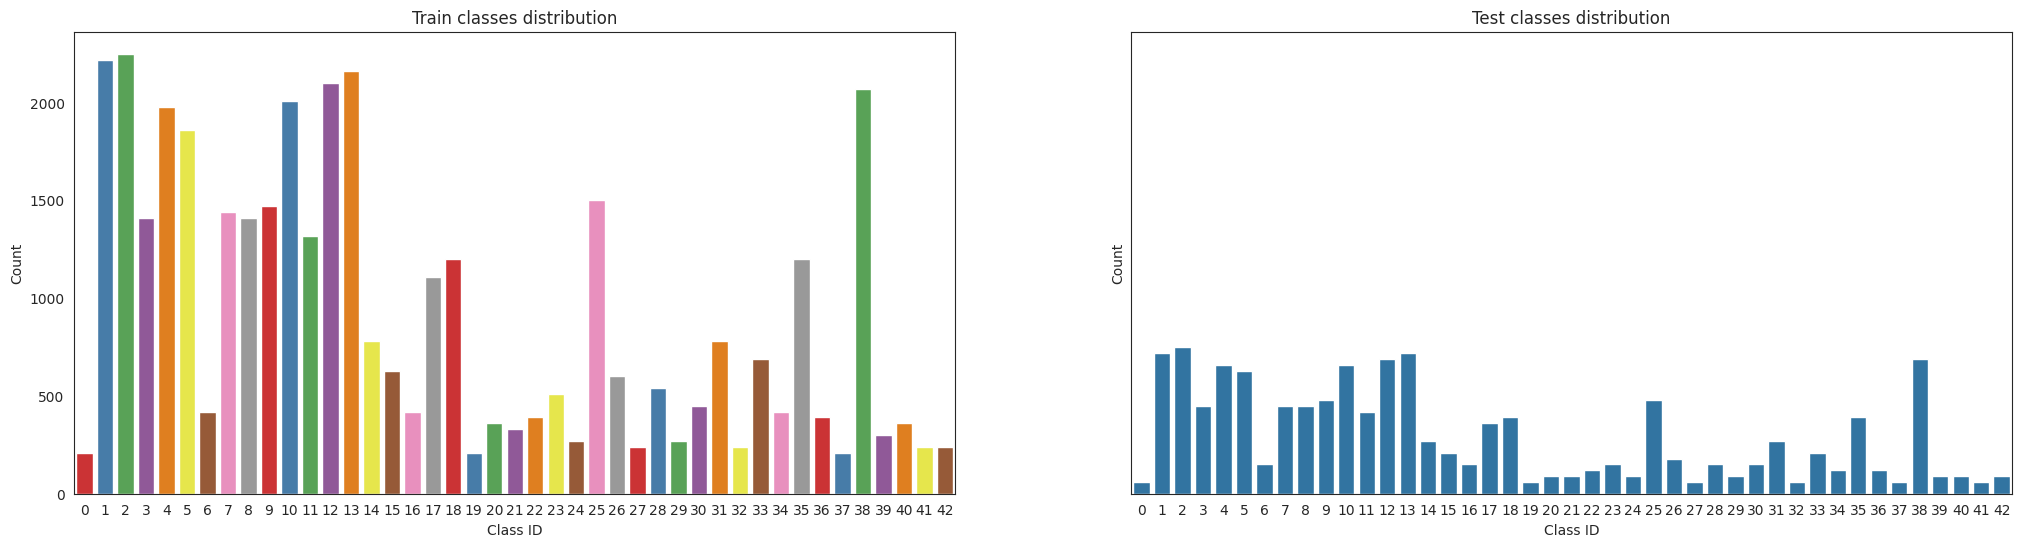

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(25, 6))
# Train set
axs[0].set_title('Train classes distribution')
axs[0].set_xlabel('Class ID')
axs[0].set_ylabel('Count')
sns.countplot(x='ClassId', data=trainDf, ax=axs[0], palette="Set1", legend=False)
# Test set
axs[1].set_title('Test classes distribution')
axs[1].set_xlabel('Class ID')
axs[1].set_ylabel('Count')
sns.countplot(x='ClassId', data=testDf, ax=axs[1])


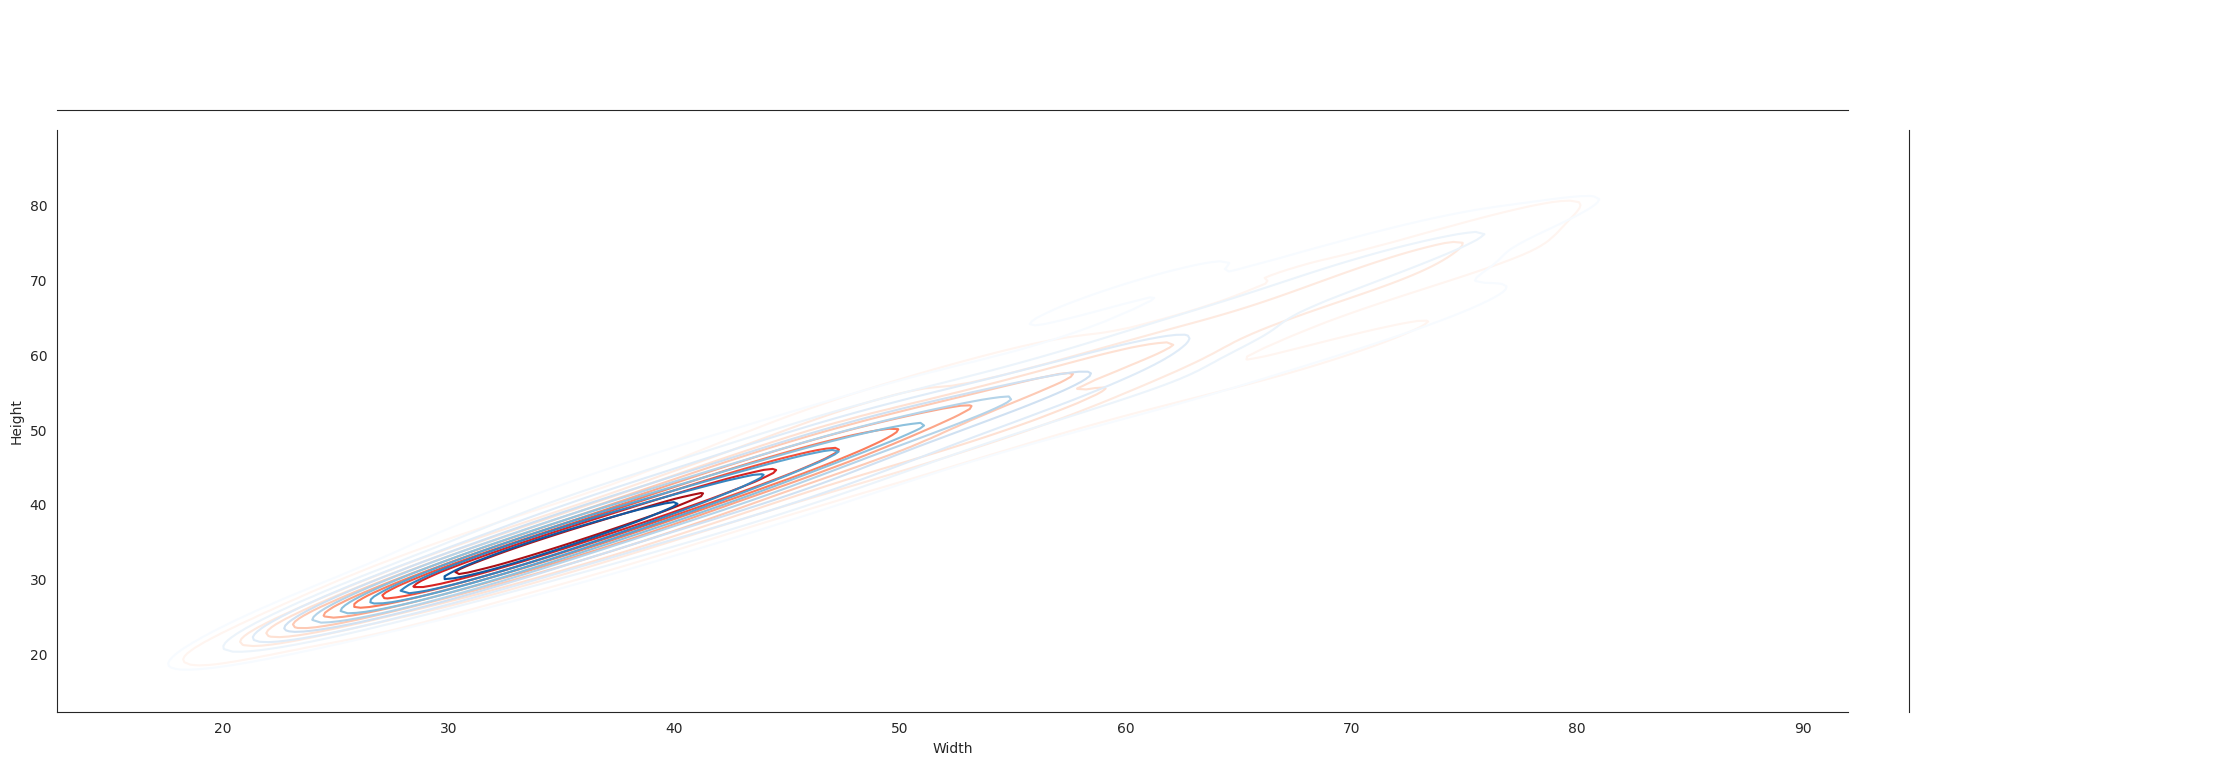

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

#Filtering for small sets
trainDfDpiSubset = trainDf[(trainDf.Width < 80) & (trainDf.Height < 80)]
testDfDpiSubset  = testDf[(testDf.Width < 80) & (testDf.Height < 80)]

#Small Samples
train_sample = trainDfDpiSubset.sample(n=500, random_state=42)
test_sample  = testDfDpiSubset.sample(n=500, random_state=42)

#Plotting of KDE
g = sns.JointGrid(x="Width", y="Height", data=train_sample)

sns.kdeplot(
    data=train_sample,
    x="Width",
    y="Height",
    cmap="Reds",
    fill=False,
    ax=g.ax_joint
)
sns.kdeplot(
    data=test_sample,
    x="Width",
    y="Height",
    cmap="Blues",
    fill=False,
    ax=g.ax_joint
)

g.fig.set_figwidth(25)
g.fig.set_figheight(8)
plt.show()


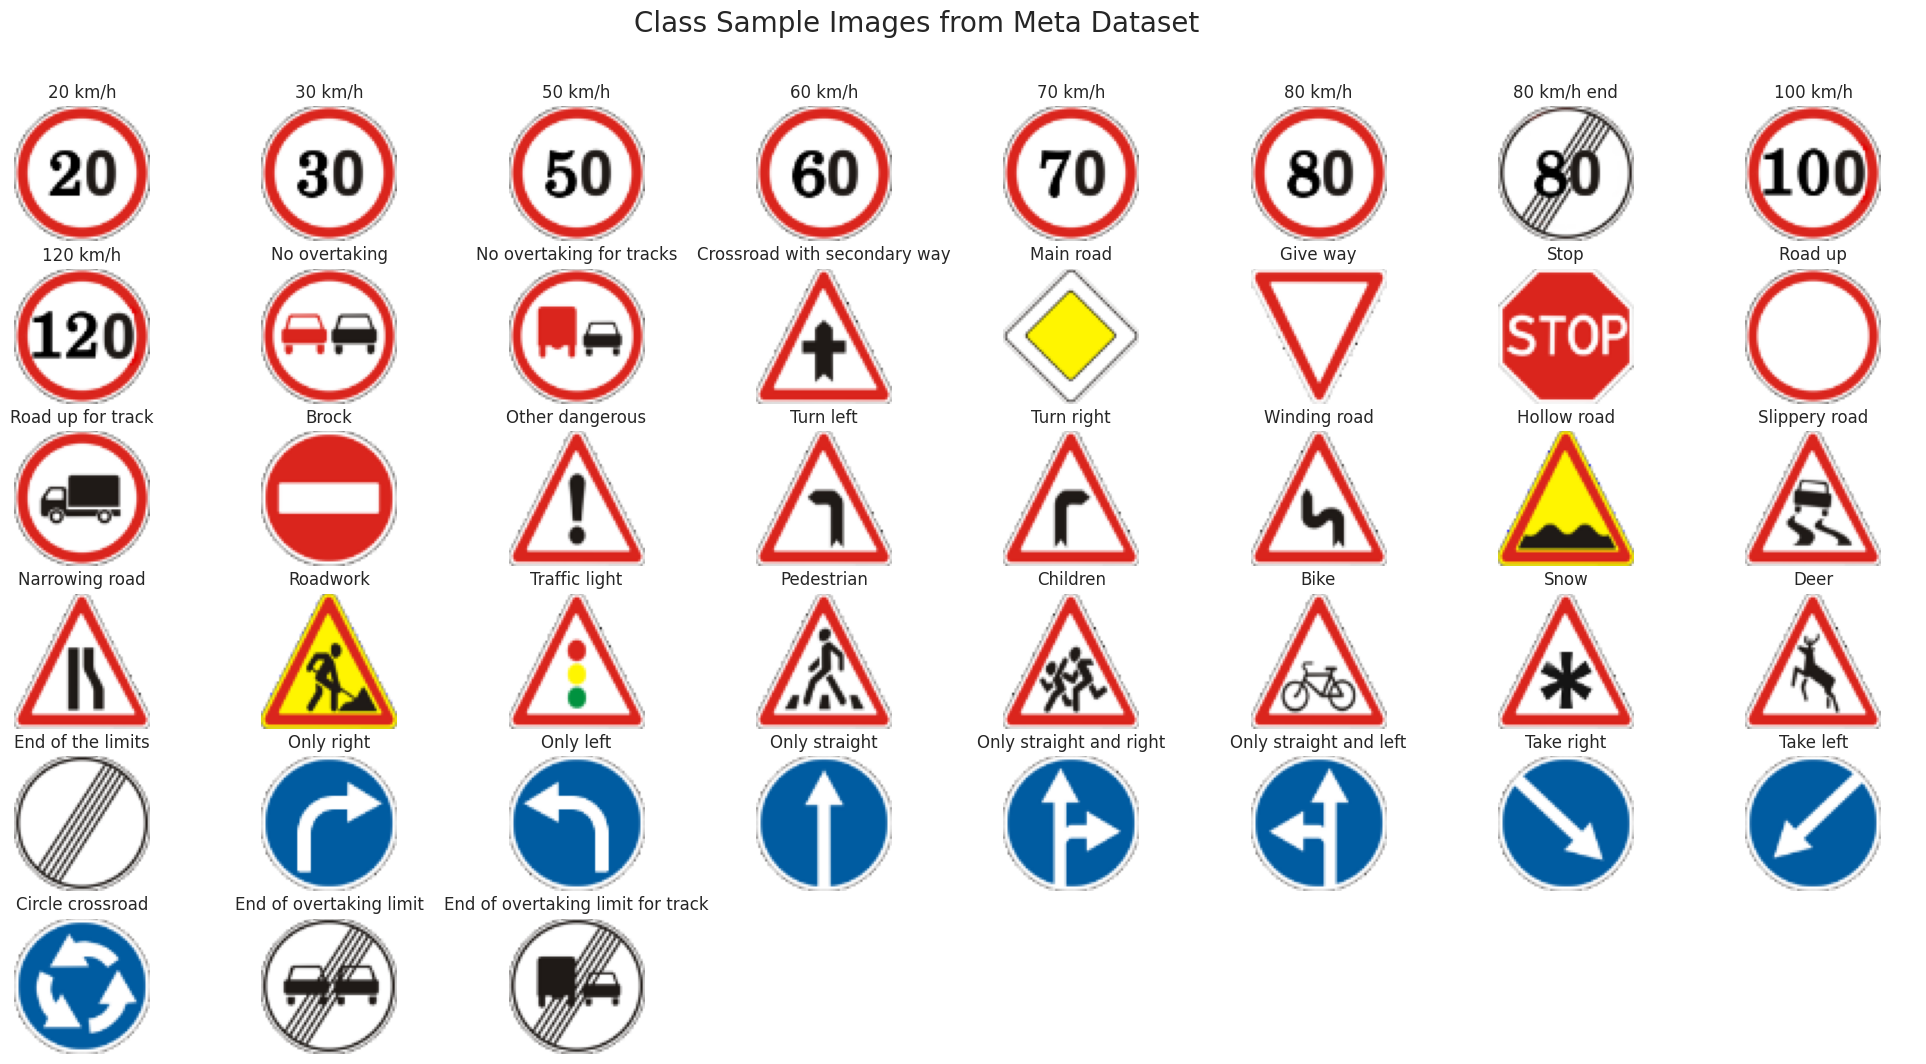

In [39]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("white")

rows = 6
cols = 8
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 12))
plt.subplots_adjust(top=0.9)
metaDf = metaDf.sort_values(by=['ClassId'])
idx = 0

for i in range(rows):
    for j in range(cols):
        if idx > 42:
            axs[i, j].axis("off")
            continue

        img_path = metaDf["Path"].tolist()[idx]

        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        if img is None:
            print(f"Image not found or unreadable at: {img_path}")
            axs[i, j].axis("off")
            idx += 1
            continue

# Handle transparent images
        if img.shape[-1] == 4:
            img[np.where(img[:, :, 3] == 0)] = [255, 255, 255, 255]

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (60, 60))

        axs[i, j].imshow(img)
        axs[i, j].set_facecolor((1.0, 0.47, 0.42))
        axs[i, j].set_title(labels[int(metaDf["ClassId"].tolist()[idx])])
        axs[i, j].axis("off")

        idx += 1

plt.suptitle("Class Sample Images from Meta Dataset", fontsize=20)
plt.show()


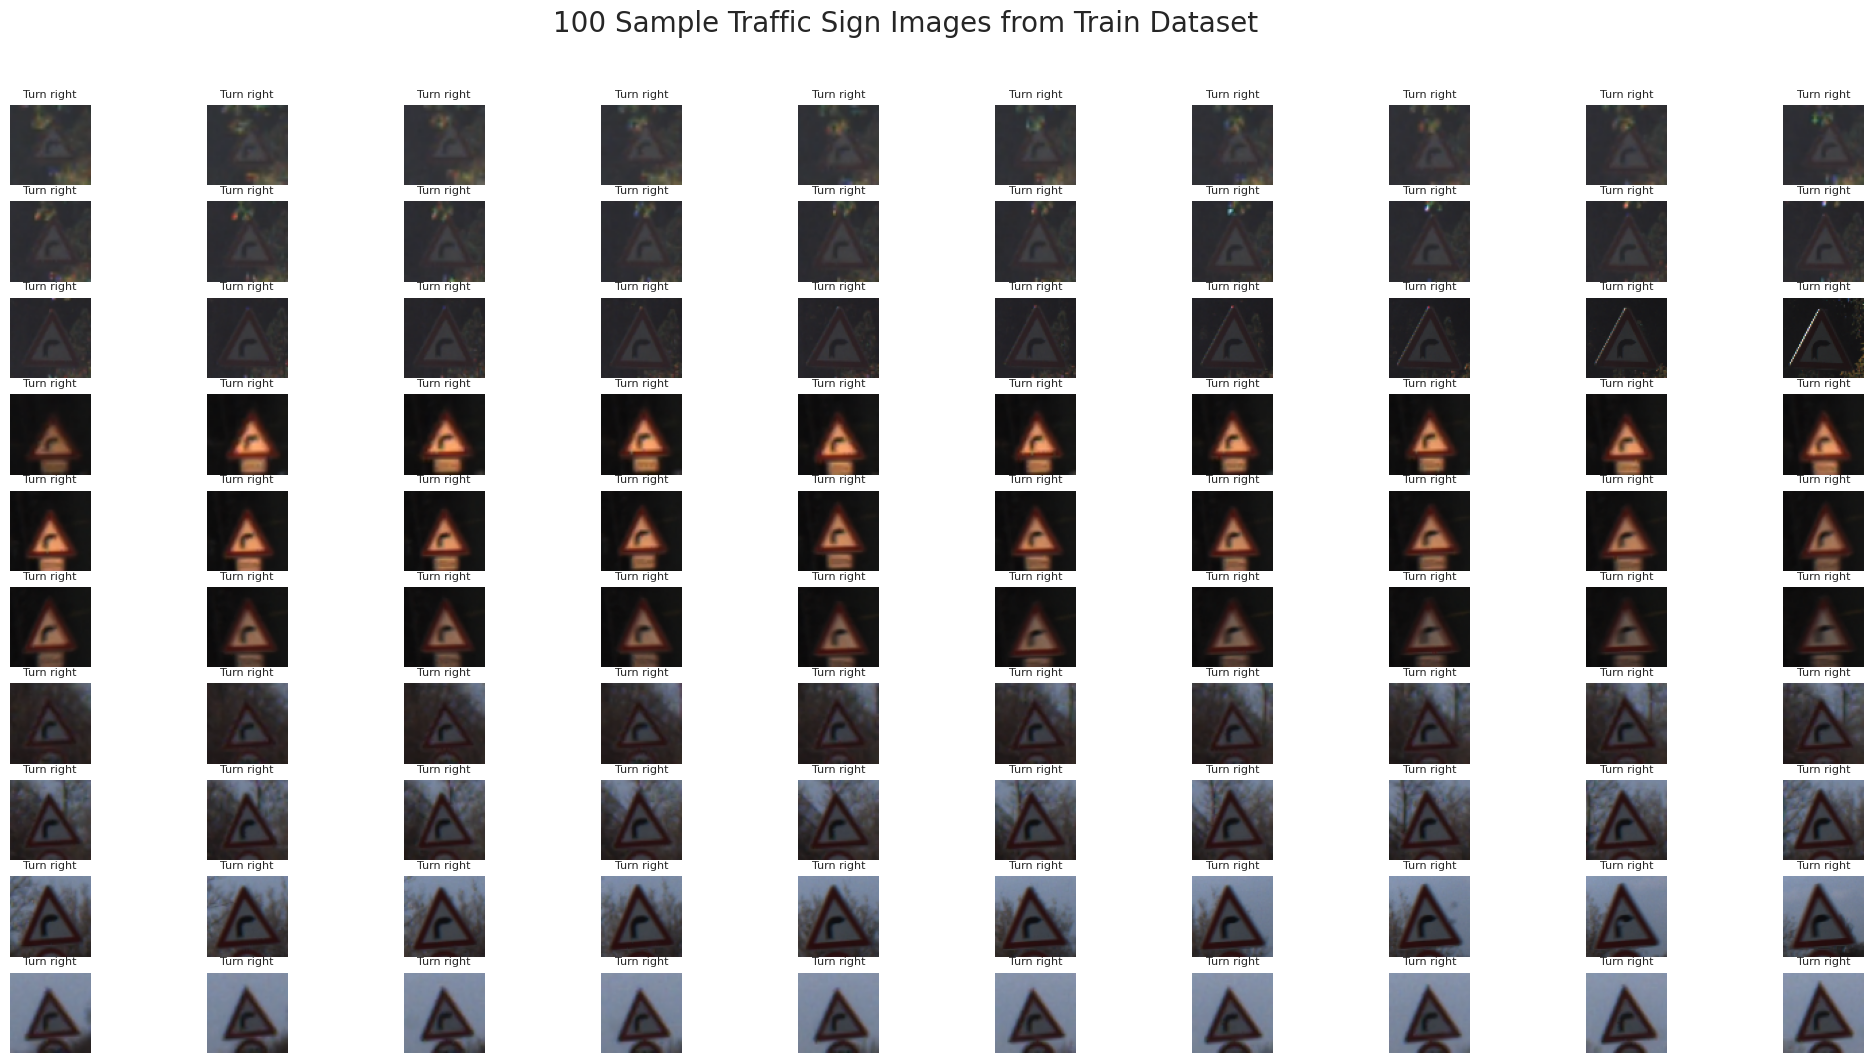

In [40]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

rows = 10
cols = 10
fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(25, 12))
plt.subplots_adjust(top=0.9)
idx = 0

for i in range(rows):
    for j in range(cols):
        if idx >= len(trainDf):
            axs[i, j].axis("off")
            continue

        img_path = trainDf["Path"].tolist()[idx]
        class_id = trainDf["ClassId"].tolist()[idx]

        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)

        if img is None:
            print(f"Image not found or unreadable at: {img_path}")
            axs[i, j].axis("off")
            idx += 1
            continue
#Handling transparent images
        if img.shape[-1] == 4:
            img[np.where(img[:, :, 3] == 0)] = [255, 255, 255, 255]

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (60, 60))

        axs[i, j].imshow(img)
        axs[i, j].set_title(labels[int(class_id)], fontsize=8)
        axs[i, j].axis("off")

        idx += 1

plt.suptitle("100 Sample Traffic Sign Images from Train Dataset", fontsize=20)
plt.show()


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout


In [48]:
import os
import numpy as np
from PIL import Image

data = []
labels = []
classes = 43
cur_path = '/content/traffic_dataset/Train/'

#Loop going through each folder
for i in range(classes):
    path = os.path.join(cur_path, str(i))

    if not os.path.exists(path):
        print(f"Directory not found: {path}")
        continue

    images = os.listdir(path)

    for img_name in images:
        try:
            img_path = os.path.join(path, img_name)
            image = Image.open(img_path)
            image = image.resize((30, 30))
            image = np.array(image)

            data.append(image)
            labels.append(i)
        except Exception as e:
            print(f"Error loading image {img_name} from class {i}: {e}")


Converting Lists into NumPy Array

In [49]:
data = np.array(data)
labels = np.array(labels)
print(data.shape, labels.shape)


(39209, 30, 30, 3) (39209,)


Splitting training and testing dataset

In [50]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


Model Building

In [53]:
from keras.layers import Input

model = Sequential()
model.add(Input(shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))


Compilation Of the Model

In [55]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=43)
y_test = to_categorical(y_test, num_classes=43)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 15
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))


Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 128s 128ms/step - accuracy: 0.3169 - loss: 2.9879 - val_accuracy: 0.9170 - val_loss: 0.3599
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 132s 118ms/step - accuracy: 0.8185 - loss: 0.6189 - val_accuracy: 0.9490 - val_loss: 0.2010
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 116s 118ms/step - accuracy: 0.8864 - loss: 0.3900 - val_accuracy: 0.9661 - val_loss: 0.1192
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 141s 117ms/step - accuracy: 0.9068 - loss: 0.3295 - val_accuracy: 0.9760 - val_loss: 0.0853
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 139s 113ms/step - accuracy: 0.9184 - loss: 0.2949 - val_accuracy: 0.9742 - val_loss: 0.1009
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 145s 117ms/step - accuracy: 0.9222 - loss: 0.2753 - val_accuracy: 0.9759 - val_loss: 0.0834
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 141s 116ms/step - accuracy: 0.9329 - loss: 0.2461 - val_accuracy: 0.9844 - val_loss: 0.0588
Epoch 8/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 115s 118ms/step - accuracy: 0.9385 -

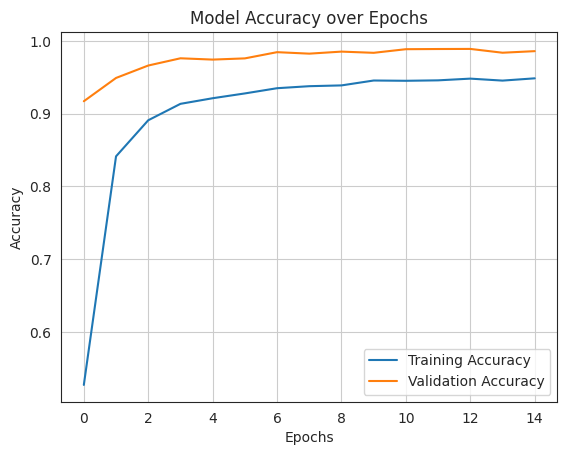

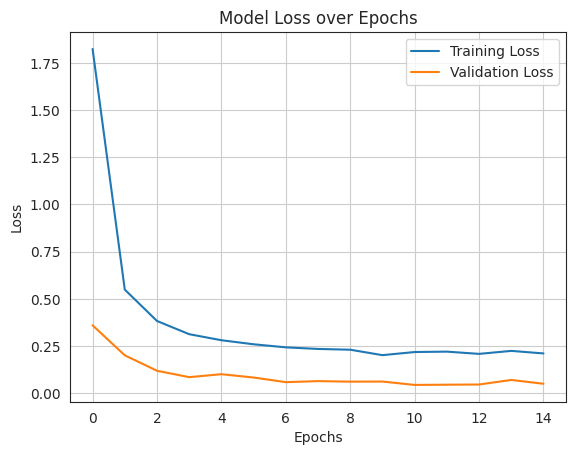

In [56]:
import matplotlib.pyplot as plt

#Plotting Training and Validation Accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
#Plotting Training and Validation Loss
plt.figure(1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [59]:
import pandas as pd
import numpy as np
from PIL import Image
import os
test_csv_path = '/content/traffic_dataset/Test.csv'
test_data = pd.read_csv(test_csv_path)

X_test = []
y_test = []

for index, row in test_data.iterrows():
    img_name = row['Path'] if 'Path' in row else row['Filename']
    label = row['ClassId']

    try:
        image_path = os.path.join('/content/traffic_dataset', img_name)
        image = Image.open(image_path)
        image = image.resize((30, 30))
        image = np.array(image)
        X_test.append(image)
        y_test.append(label)
    except Exception as e:
        print(f"Error loading image {img_name}: {e}")
X_test = np.array(X_test)
y_test = np.array(y_test)


In [61]:
X_test = np.array(data)
pred_prob = model.predict(X_test)                # shape: (num_samples, 43)
pred = np.argmax(pred_prob, axis=1)              # shape: (num_samples,)
from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred))

1226/1226 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step
0.9880894692545079


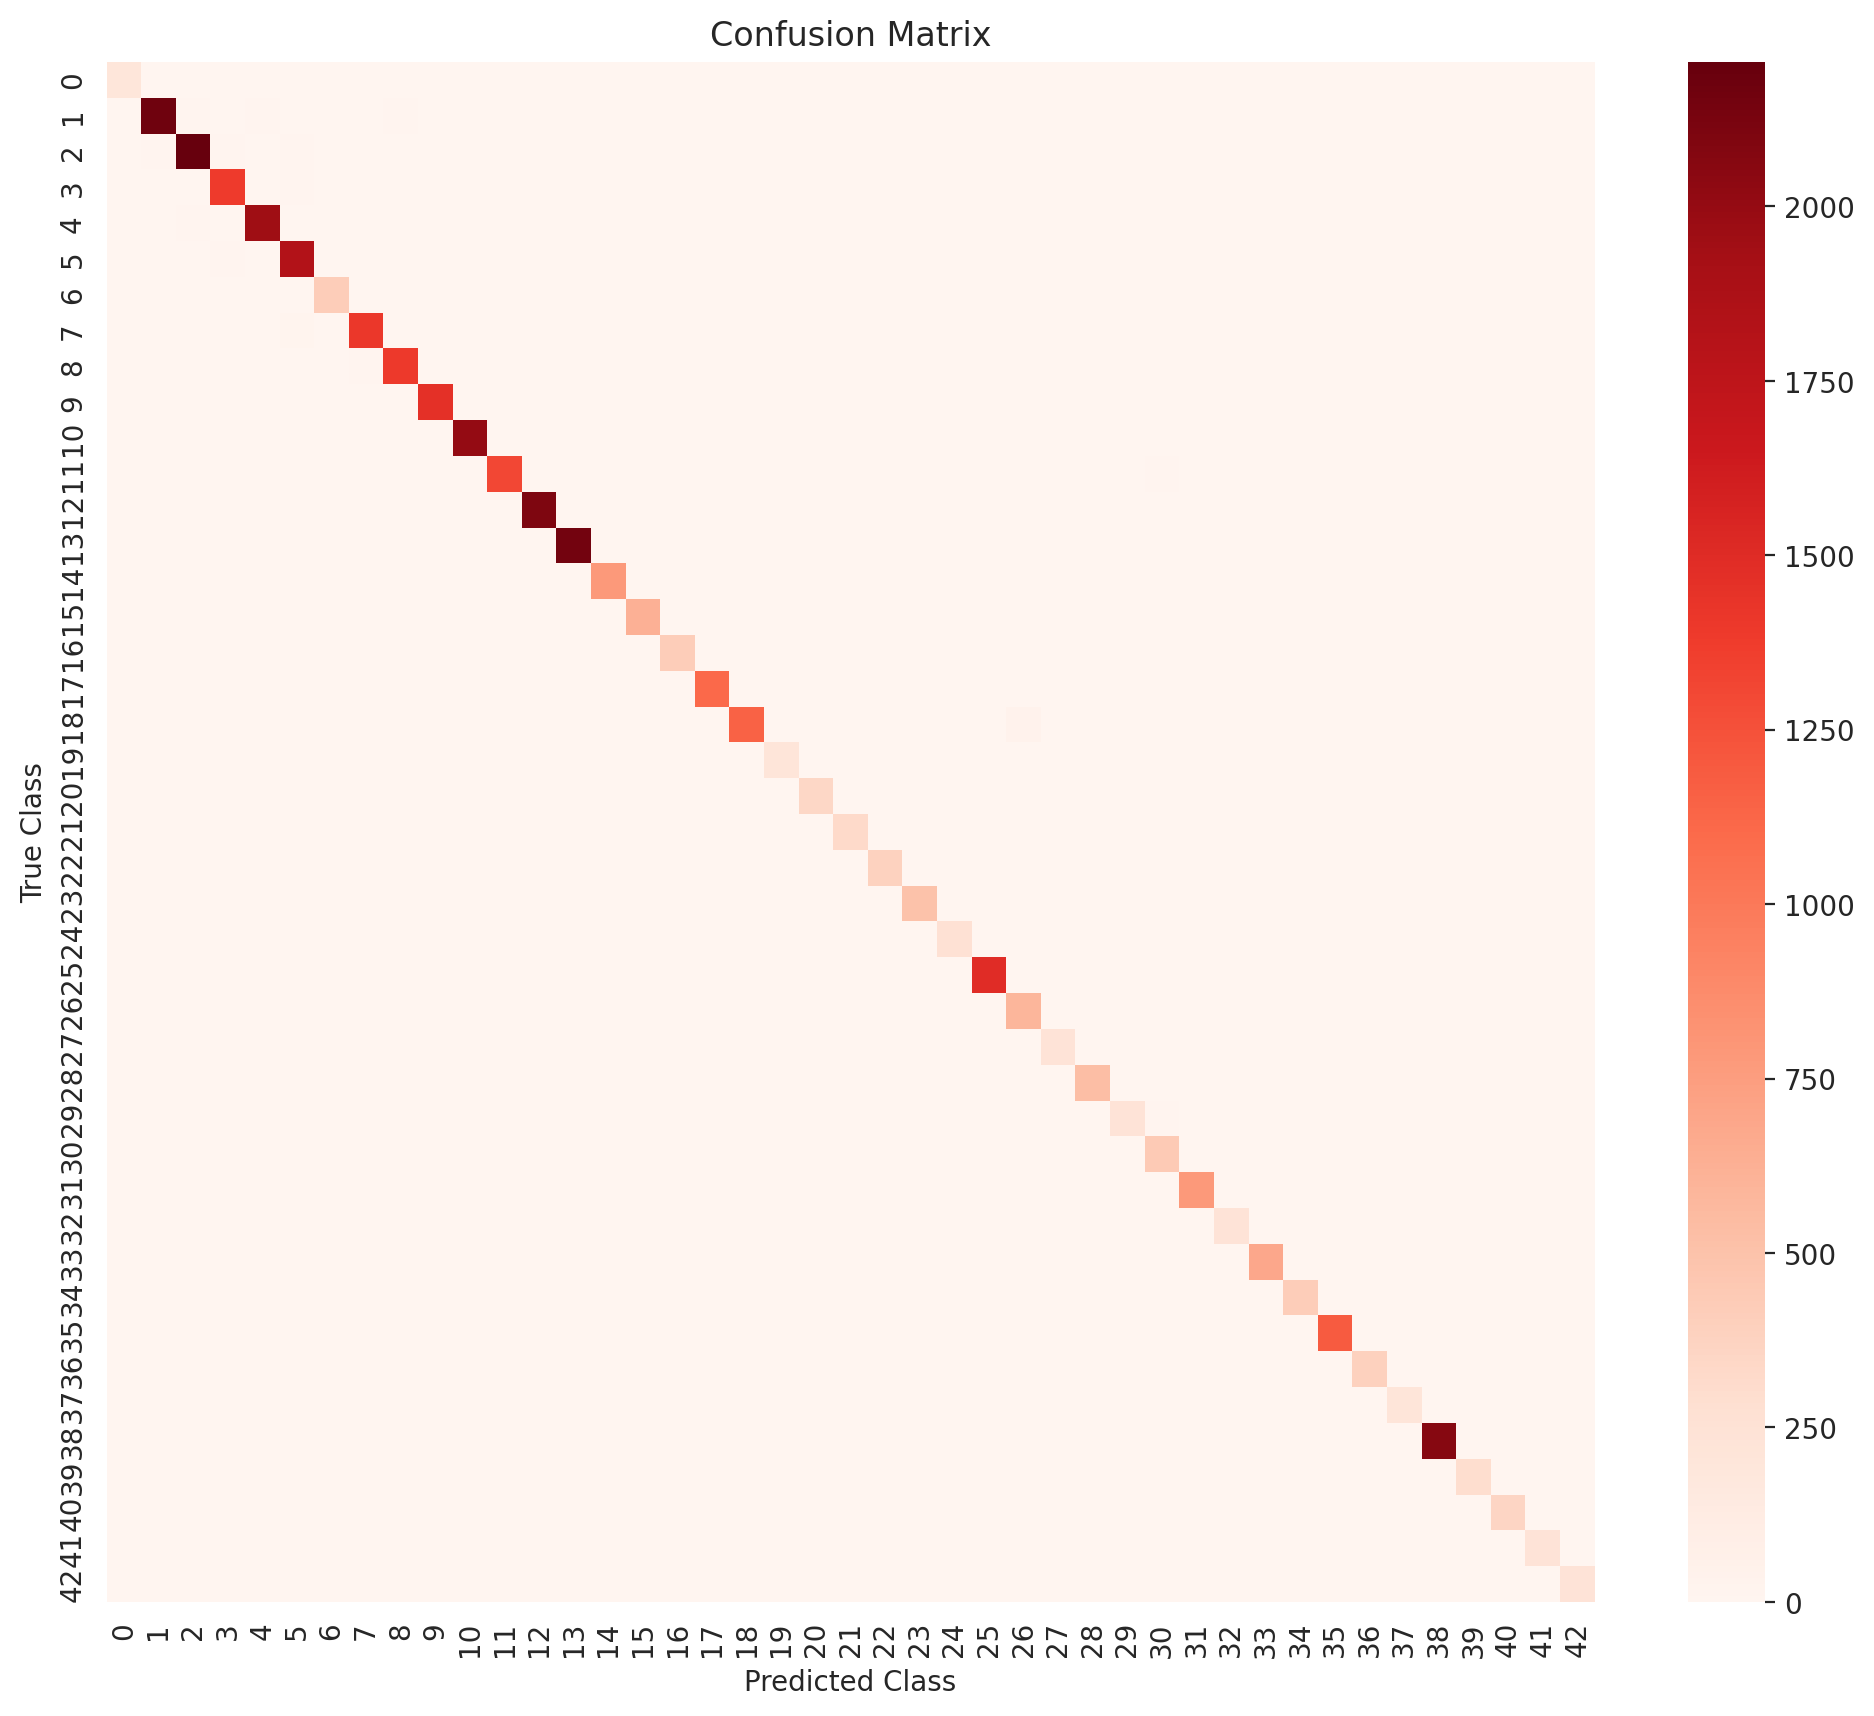

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Reds")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()